In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2

def load_images(folder, img_size=(64, 64)):
    images = []
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)
        if filepath.endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Load grayscale
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

folder_path = r"/content/drive/MyDrive/ImageML"
data = load_images(folder_path)
print(f"Loaded data shape: {data.shape}")

Loaded data shape: (21196, 64, 64)


In [3]:
from sklearn.model_selection import train_test_split

# Split data into train (80%) and test (20%) sets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

# Define image_shape based on your image dimensions
image_shape = (64, 64)  # Adjust the dimensions as needed

# Reshape data for input to models
X_train = X_train.reshape(X_train.shape[0], *image_shape)
X_test = X_test.reshape(X_test.shape[0], *image_shape)

print(X_train.shape)

(16956, 64, 64)


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Input

def build_generator(latent_dim, output_shape):
    # Use Input layer instead of input_dim
    input_tensor = Input(shape=(latent_dim,))
    x = layers.Dense(8 * 8 * 128, activation='relu')(input_tensor)
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    output_tensor = layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    return model

def build_discriminator(input_shape):
    # Use Input layer instead of input_shape
    input_tensor = Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(input_tensor)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    output_tensor = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    return model

def build_encoder(input_shape, latent_dim):
    # Use Input layer instead of input_shape
    input_tensor = Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    output_tensor = layers.Dense(latent_dim, activation='linear')(x)  # Latent space representation
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    return model

In [9]:
import tensorflow as tf
import numpy as np

# Initialize lists to store accuracy and loss values
d_accuracies = []  # To track discriminator accuracy
d_losses = [] # To track discriminator loss
g_losses = []

# Use legacy Adam optimizer to avoid variable recognition issues
optimizer_d = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_g = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Add channel dimension to image_shape
image_shape = X_train.shape[1:]  # Ensure the correct shape of the input
image_shape = (*image_shape, 1)  # Add channel dimension (e.g., (64, 64, 1))

latent_dim = 10  # Define latent dimension for GAN

# Build the models
encoder = build_encoder(input_shape=image_shape, latent_dim=latent_dim)
generator = build_generator(latent_dim, image_shape)
discriminator = build_discriminator(input_shape=image_shape)

# Compile discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_d, metrics=['accuracy'])
discriminator.trainable = False

# Combine encoder, generator, and discriminator for generator training
z = tf.keras.layers.Input(shape=(latent_dim,))
generated_data = generator(z)
valid = discriminator(generated_data)
combined_model = tf.keras.Model(z, valid)
combined_model.compile(loss='binary_crossentropy', optimizer=optimizer_g)

# Training parameters
epochs = 100  # Example value, adjust as needed
batch_size = 64  # Example value, adjust as needed

# Training loop
for epoch in range(epochs):
    # Train discriminator
    real_data = data[np.random.randint(0, X_train.shape[0], batch_size)]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    synthetic_data = generator.predict(noise)

    # Train discriminator on real and fake data
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(synthetic_data, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Track discriminator accuracy and loss
    d_acc = 0.5 * (d_loss_real[1] + d_loss_fake[1])  # Average accuracy
    d_accuracies.append(d_acc)
    d_losses.append(d_loss[0])  # Loss value only

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined_model.train_on_batch(noise, real_labels)
    g_losses.append(g_loss)

    # Print progress every 10 epochs
    if epoch % 1 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]:.4f}, D Acc: {d_acc:.4f}, G Loss: {g_loss:.4f}")


2/2 [==============================] - 0s 195ms/step
Epoch 0, D Loss: 0.7410, D Acc: 0.4844, G Loss: 0.6105
2/2 [==============================] - 0s 199ms/step
Epoch 1, D Loss: 0.6940, D Acc: 0.5000, G Loss: 0.6319
2/2 [==============================] - 0s 192ms/step
Epoch 2, D Loss: 0.6714, D Acc: 0.5312, G Loss: 0.6667
2/2 [==============================] - 0s 118ms/step
Epoch 3, D Loss: 0.6495, D Acc: 0.7188, G Loss: 0.7006
2/2 [==============================] - 0s 106ms/step
Epoch 4, D Loss: 0.6274, D Acc: 0.8984, G Loss: 0.7450
2/2 [==============================] - 0s 190ms/step
Epoch 5, D Loss: 0.6102, D Acc: 0.9531, G Loss: 0.7845
2/2 [==============================] - 0s 188ms/step
Epoch 6, D Loss: 0.5905, D Acc: 0.9922, G Loss: 0.8143
2/2 [==============================] - 0s 104ms/step
Epoch 7, D Loss: 0.5584, D Acc: 0.9922, G Loss: 0.8717
2/2 [==============================] - 0s 107ms/step
Epoch 8, D Loss: 0.5305, D Acc: 0.9844, G Loss: 0.9441
2/2 [=======================

In [10]:
# Extract the latent representations
latent_representations = encoder.predict(X_test)


133/133 [==============================] - 3s 24ms/step


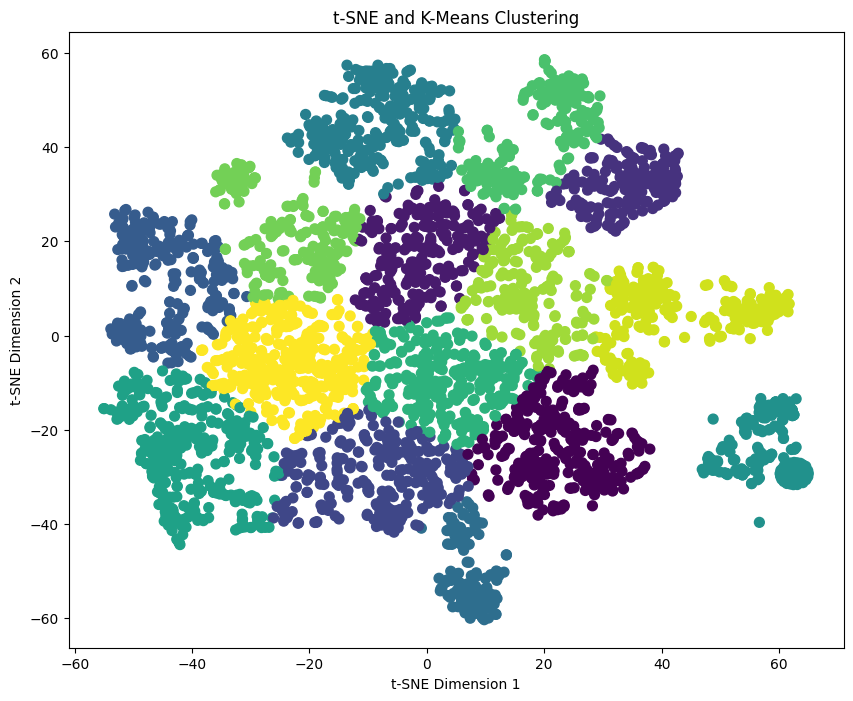

In [11]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(latent_representations)

# Cluster using KMeans in t-SNE space
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(tsne_results)

# Visualize the clustering
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("t-SNE and K-Means Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label='Cluster')
plt.show()

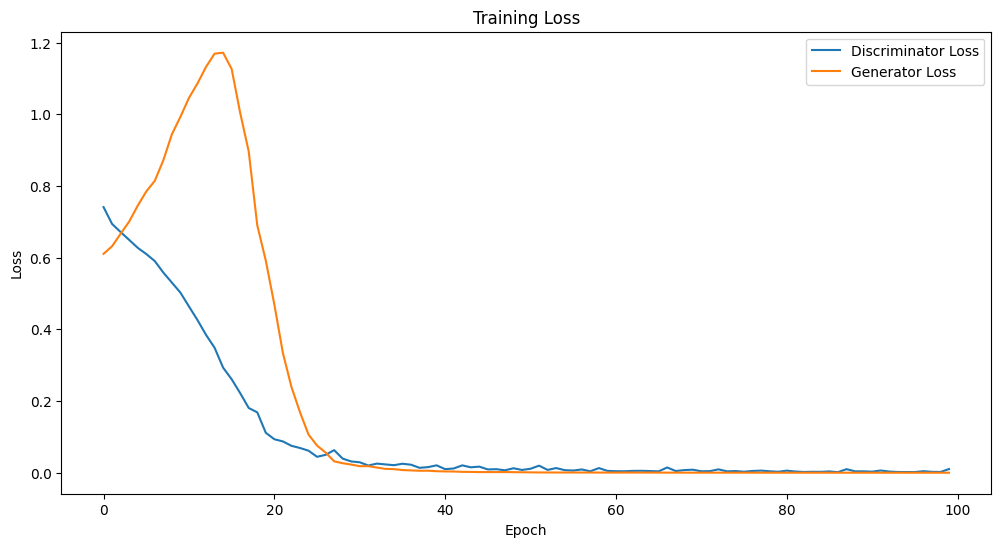

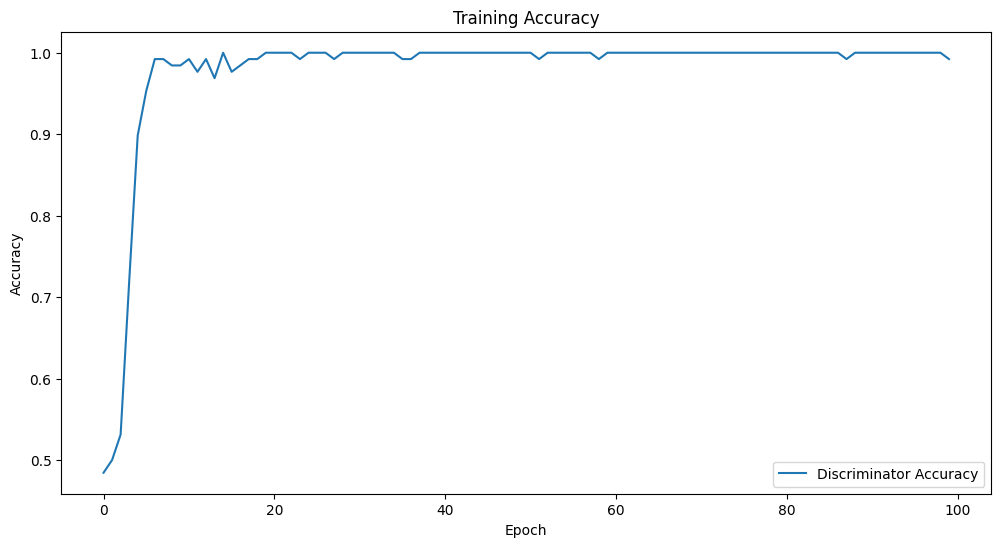

In [12]:
import matplotlib.pyplot as plt

# Plot Losses
plt.figure(figsize=(12, 6))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/ML mini project/GAN Training Loss.png')
plt.show()

# Plot Discriminator Accuracy
plt.figure(figsize=(12, 6))
plt.plot(d_accuracies, label='Discriminator Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/ML mini project/Discriminator Training Accuracy.png')
plt.show()

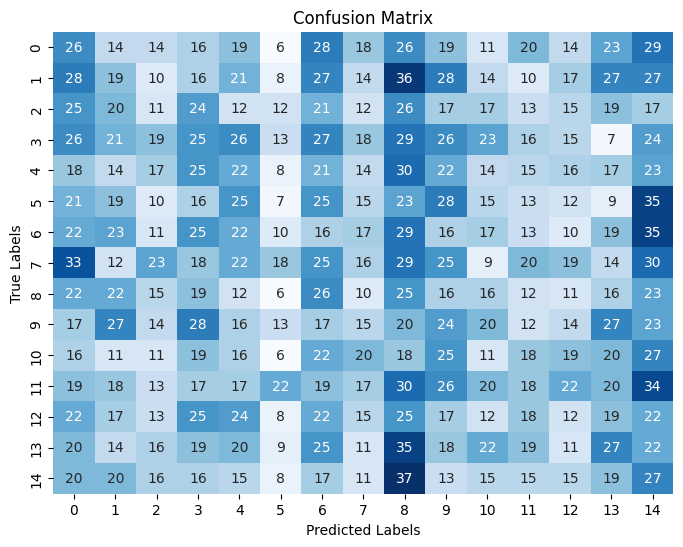

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate true labels for the test set (X_test) with the same size as clusters
true_labels = np.random.randint(0, 15, size=X_test.shape[0])

#Confusion Matrix
conf_matrix = confusion_matrix(true_labels, clusters)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=np.arange(15), yticklabels=np.arange(15))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [16]:
# Evaluate on test set
test_loss, test_acc = discriminator.evaluate(X_test, np.ones((X_test.shape[0], 1)))
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

133/133 [==============================] - 3s 21ms/step - loss: 0.0015 - accuracy: 1.0000
Test Loss: 0.0015, Test Acc: 1.0000
